# Pytorch Homework 3: 利用 stanford dog (mini) dataset 來訓練一個分類器。

## 作業說明

這次的作業總共有 4 個部份，必須完成助教提供的 ipynb 檔，在檔案中某些區塊會有 ??? 處需要完成。

0. 安裝需要使用的 package: pip install -r requirements.txt

1. 實作 Dataloader
    * 1.1. 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset。 ** (10%) **
    * 1.2. 將每一個類別以 8 : 2 的比例分割成 Training data 和 Testing data 傳至 dataloader  ** (15%) **

2. 建構 CNN model。
    * 2.1. 利用 Pytorch 內建的 CNN model 來進行訓練。 ** (10%) **
    * 2.2. 自行設計一個新的 CNN model 來進行訓練。 ** (20%) ** (至少達到 70% 以上的 Testing accuracy，否則只有一半的分數)
    * 2.3. 利用 torchsummary 來印出上面兩個模型的架構資訊。 ** (5%) **

3. 實作模型訓練和測試模型效能。 ** (30%) **
4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖並儲存下來。 ** (10%) **
    
## 作業繳交

* Deadline : 11/16 中午12:00        
    * **遲交一天打 7 折**
    * **遲交兩天打 5 折**
    * **遲交三天以上不給予分數**
    
* 繳交方式 : 請將完成的 ipynb 檔 (分成兩個版本: 內建 model 版和自己設計的版本) 以及 Loss、Training / testing accuracy 的圖片，壓縮後上傳至 moodle。
    * 建議先完成一個版本，然後將檔案複製後再完成另一個版本
    
* 壓縮檔內包含 :
    * (你的學號)\_(姓名)\_HW3_2_1.ipynb  (E.g.F77777777_王小明_HW3_2_1.ipynb) 
    * (你的學號)\_(姓名)\_HW3_2_2.ipynb  (E.g.F77777777_王小明_HW3_2_2.ipynb) 
    * 兩個版本的 Loss.png、Acc.png (Loss_2_1.png、Loss_2_2.png、Acc_2_1.png、Acc_2_2.png)
    * **格式不對的話會扣 10 分！！！**
    
* 有任何問題歡迎寄信至我的信箱
    * 曹維廷 a0903511820@gmail.com

In [19]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torchsummary import summary

plt.ion()

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Part 1：Dataloader 實作

In [21]:
# 1.1. 填入 ??? 的部份
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\MarkYan\\OneDrive\\桌面\\Introduction_To_Artificial_Intelligence\\hw3\\stanford_dog'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

use_gpu = torch.cuda.is_available()


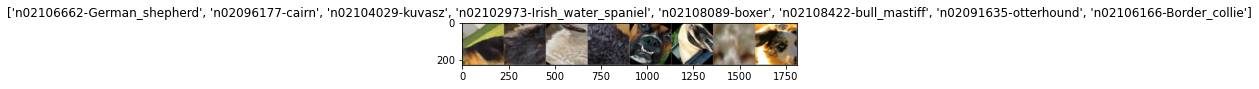

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Part 2: 建立 CNN Model

In [23]:
# 2.2. 自行設計一個新的 CNN model

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'Training':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                
        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = models.vgg16(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models


if use_gpu:
    model_ft = model_ft.cuda()
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()

### Setting

依據需求調整參數

In [24]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00016, momentum=0.9)

### 3. 實作模型訓練和測試模型效能

In [25]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['Testing']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return  

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=20)

Epoch 0/19
----------
Training Loss: 0.6203 Acc: 0.0300
Testing Loss: 0.4966 Acc: 0.0946

Epoch 1/19
----------
Training Loss: 0.4860 Acc: 0.1099
Testing Loss: 0.3593 Acc: 0.2502

Epoch 2/19
----------
Training Loss: 0.4082 Acc: 0.1869
Testing Loss: 0.2765 Acc: 0.3930

Epoch 3/19
----------
Training Loss: 0.3616 Acc: 0.2578
Testing Loss: 0.2307 Acc: 0.4576

Epoch 4/19
----------
Training Loss: 0.3258 Acc: 0.3108
Testing Loss: 0.1828 Acc: 0.5686

Epoch 5/19
----------
Training Loss: 0.2996 Acc: 0.3643
Testing Loss: 0.1685 Acc: 0.5888

Epoch 6/19
----------
Training Loss: 0.2833 Acc: 0.3908
Testing Loss: 0.1452 Acc: 0.6512

Epoch 7/19
----------
Training Loss: 0.2675 Acc: 0.4157
Testing Loss: 0.1349 Acc: 0.6727

Epoch 8/19
----------
Training Loss: 0.2562 Acc: 0.4459
Testing Loss: 0.1329 Acc: 0.6744

Epoch 9/19
----------
Training Loss: 0.2453 Acc: 0.4643
Testing Loss: 0.1251 Acc: 0.6883

Epoch 10/19
----------
Training Loss: 0.2416 Acc: 0.4620
Testing Loss: 0.1219 Acc: 0.7008

Epoch 11/

In [28]:
summary(model_ft, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [ ]:
plt.figure()

plt.plot('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc)) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.show()

plt.figure()

plt.plot('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60)) # plot your training accuracy
plt.plot('Best val Acc: {:4f}'.format(best_acc)) # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.show()